# Imports

In [1]:
%matplotlib inline
import random
import datetime
import inflection
import matplotlib
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb 

from scipy                 import stats as ss
from boruta                import BorutaPy
from IPython.display       import Image
from IPython.core.display  import HTML
from matplotlib.gridspec   import GridSpec

from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


In [2]:
# configurações globais
sns.set_theme()                                                   # gráfico
plt.rcParams['figure.figsize'] = [20, 12]                         # gráfico
pd.set_option('display.float_format', lambda x: '%.5f' % x)       # notação científica

In [41]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y) # tabela de contingência, necessária para calcular o chi2

    chi2 = ss.chi2_contingency(cm)[0]  #chi2_contingency calcula 4 coisas, queremos só a primeira.

    n = cm.sum().sum() # o primeiro sum() soma os elementos de todas as colunas, o segundo soma todas as somas anteriores
    r, k = cm.shape  # r: linhas, k: colunas de cm

    # correção do viés

    phi2_til = max(0, chi2/n - (k-1)*(r-1)/(n-1))
    k_til = k - ((k-1)**2)/(n-1)
    r_til = r - ((r-1)**2)/(n-1)

    v_til = np.sqrt(phi2_til/(min(k_til - 1, r_til -1)))
    
    return v_til


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    return pd.DataFrame({'Modelo': model_name, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse}, index=[0])


def mean_percentege_error(y, yhat):
    return np.mean( (y-yhat) / y)

def cross_validation(df, model, iterations, model_name, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in range(1, iterations+1):
        
        if verbose:
            print(f'Iteração: {k}')
        
        # filtros para os conjuntos de dados de treino e validação
        validation_start_date = df['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = df['date'].max() + datetime.timedelta(days=(k-1)*6*7)

        # conjunto de dados de treino e validação filtrados
        training = df[df['date'] < validation_start_date]
        validation = df[(df['date'] >= validation_start_date) & (df['date'] < validation_end_date)]

        # conjunto de dados de treino
        x_training = training.drop(['date', 'sales'], axis=1)
        y_training = training['sales']

        # conjunto de dados de validação
        x_validation = validation.drop(['date', 'sales'], axis=1)
        y_validation = validation['sales']

        # treinamento do modelo
        m = model.fit(x_training, y_training)

        # predição do modelo
        yhat = m.predict(x_validation)

        # análise do erro
        m_result = ml_error(model_name, np.expm1(y_validation), np.expm1(yhat))

        # cross-validation
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
        k += 1

    cv_dic = {'Nome do Modelo':model_name,
              'MAE CV': np.round(np.mean(mae_list), 4).astype('str') + ' +/- ' + np.round(np.std(mae_list), 4).astype('str'),
              'MAPE CV': np.round(np.mean(mape_list), 4).astype('str') + ' +/- ' + np.round(np.std(mape_list), 4).astype('str'),
              'RMSE CV': np.round(np.mean(rmse_list), 4).astype('str') + ' +/- ' + np.round(np.std(rmse_list), 4).astype('str')}    

    return pd.DataFrame(cv_dic, index=[0])

## Loading data

In [94]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

In [95]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [96]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [97]:
# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1 Descrição dos Dados


In [98]:
df1 = df_raw.copy()

## 1.1 Rename Columns


In [99]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

cols_new = []

for c in cols_old:
    cols_new.append(inflection.underscore(c))
    
df1.columns = cols_new

## 1.2 Data Dimension

In [100]:
print(f'Número de Linhas: {df1.shape[0]}')
print(f'Número de Colunas: {df1.shape[1]}')

Número de Linhas: 1017209
Número de Colunas: 18


## 1.3 Data Types

In [142]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [101]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [102]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [103]:
# competition_distance
# as distância que não existem vamos colocar 200000, que é um valor muito maior que a maior distância
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if np.isnan(x) else x)

# competition_open_since_month    
# vamos completar os Na's com o mês da coluna 'date'
df1['competition_open_since_month'] = df1[['date','competition_open_since_month']].apply(lambda x: x['date'].month
                                                                                        if np.isnan(x['competition_open_since_month'])
                                                                                        else x['competition_open_since_month'], axis=1)

# competition_open_since_year   
# vamos completar os Na's com o ano da coluna 'date'
df1['competition_open_since_year'] = df1[['date','competition_open_since_year']].apply(lambda x: x['date'].year
                                                                                        if np.isnan(x['competition_open_since_year'])
                                                                                        else x['competition_open_since_year'], axis=1)


# promo2_since_week      

df1['promo2_since_week'] = df1[['date','promo2_since_week']].apply(lambda x: x['date'].week
                                                                   if np.isnan(x['promo2_since_week'])
                                                                   else x['promo2_since_week'], axis=1)

# promo2_since_year   

df1['promo2_since_year'] = df1[['date','promo2_since_year']].apply(lambda x: x['date'].year
                                                                   if np.isnan(x['promo2_since_year'])
                                                                   else x['promo2_since_year'], axis=1)

# promo_interval  
df1['promo_interval'].fillna(0, inplace=True)

month_map = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map)


df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 
                                                                   else 1 if x['month_map'] in x['promo_interval'].split(',')
                                                                   else 0, axis=1)


KeyboardInterrupt: 

## 1.6 Change Types

In [146]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [147]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(include=['object'])

### 1.7.1 Num Attributes

In [148]:
# Central Tendency
# média
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
# mediana
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion Tendency
dt1 = pd.DataFrame(num_attributes.apply(np.std)).T
dt2 = pd.DataFrame(num_attributes.apply(min)).T
dt3 = pd.DataFrame(num_attributes.apply(max)).T
dt4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dt5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dt6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

df_statistic = pd.concat([dt2, dt3, dt4, ct1, ct2, dt1, dt5, dt6]).T.reset_index()

In [149]:
# Renomeando as colunas
df_statistic.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [150]:
df_statistic

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


In [151]:
# sns.displot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [152]:
cat_attributes.apply(lambda x: len(x.unique()))

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

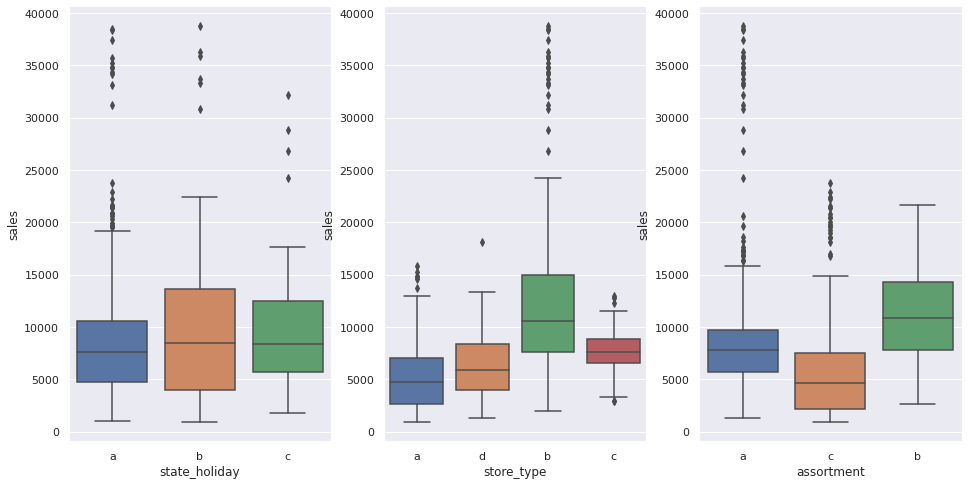

In [153]:
aux1 = df1[(df1['sales'] > 0) & (df1['state_holiday'] != '0')]

plt.subplot(1, 3, 1)
a1 = sns.boxplot(x='state_holiday', y='sales', data=aux1)
a1.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 2)
a2 = sns.boxplot(x='store_type', y='sales', data=aux1)
a2.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 3)
a3 = sns.boxplot(x='assortment', y='sales', data=aux1)
a3.figure.set_size_inches(16, 8)

In [154]:
df1.to_csv('datasets/data_train_store.csv', index=False)

# 2 Feature Engineering

In [104]:
df2 = pd.read_csv('datasets/data_train_store.csv', low_memory=False)

df2['date'] = pd.to_datetime(df2['date'])

## 2.1 Mapa Mental de Hipóteses

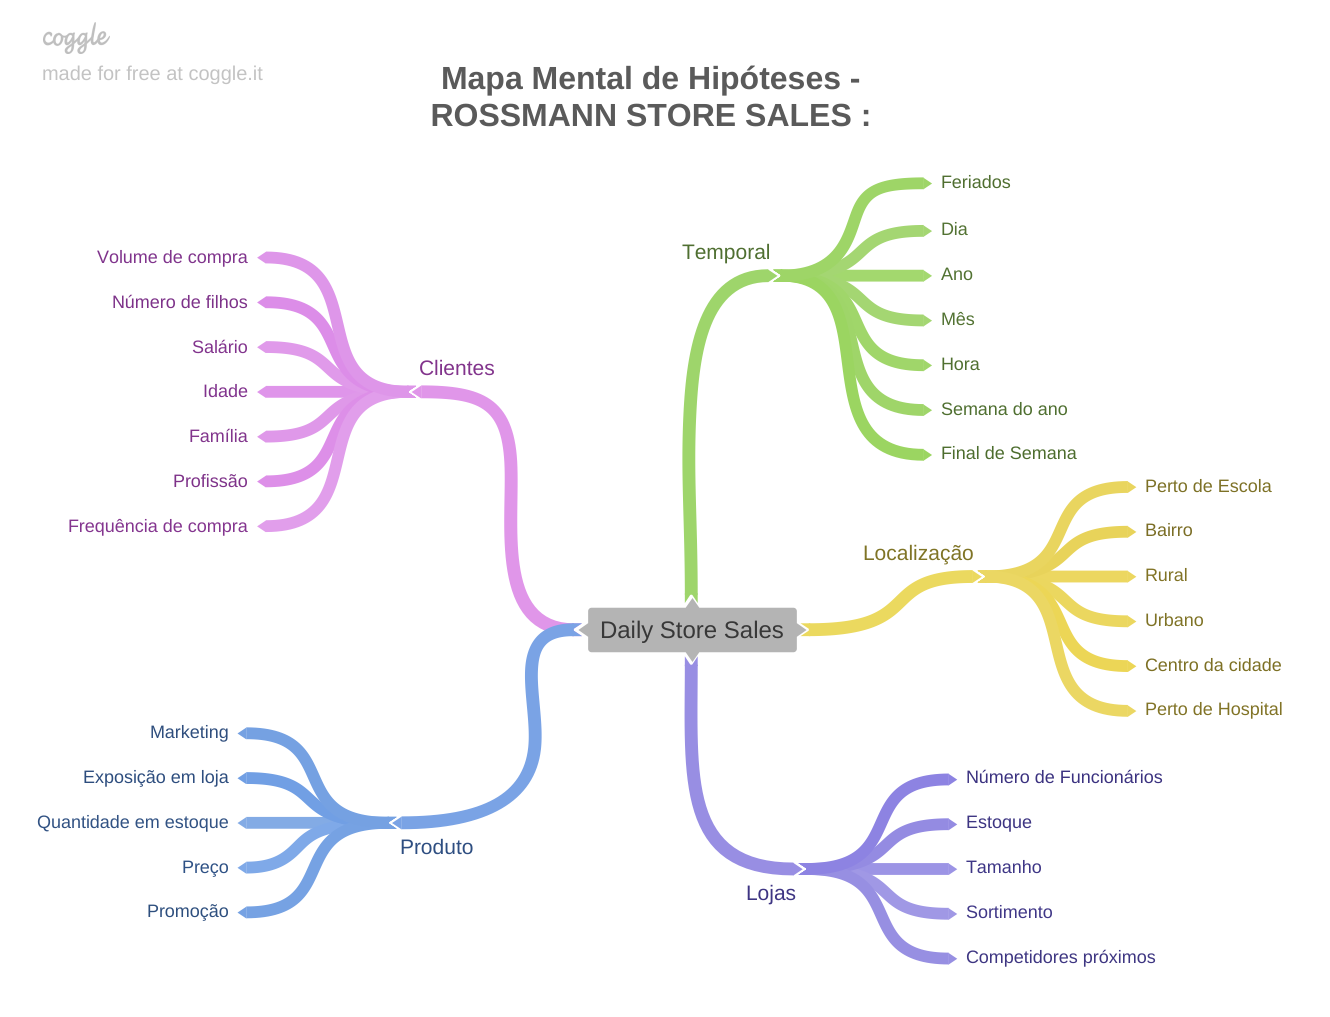

In [156]:
Image('img/mindmap_hypoteses.png')

## 2.2 Criação das Hipóteses

### 2.2.1 Hipóteses de Lojas

**H1.** Lojas com número maior de funcionários deveriam vender mais.

**H2.** Lojas com maior capacidade de estoque deveriam vender mais.

**H3.** Lojas com maior porte deveriam vender mais.

**H4.** Lojas com maior sortimentos deveriam vender mais.

**H5.** Lojas com competidores mais próximos deveriam vender menos.

**H6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2 Hipóteses dos Produtos 

**H1.** Lojas que investem mais em Marketing deveriam vender mais

**H2.** Lojas com maior exposição de produto deveriam vender mais.

**H3.** Lojas com produtos com preço menor deveriam vender mais.

**H5.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**H6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**H7.** Lojas com mais dias de promoção deveriam vender mais.

**H8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3 Hipóteses Temporais

**H1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**H2.** Lojas deveriam vender mais ao longo dos anos.

**H3.** Lojas deveriam vender mais no segundo semestre do ano.

**H4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**H5.** Lojas deveriam vender menos aos finais de semana.

**H6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.2.4 Lista Final de Hipóteses 

Depois de pensar em várias hipóteses, vamos selecionar aquelas que podemos analisar com dados que já temos agora.

**H1.** Lojas com maior sortimentos deveriam vender mais.

**H2.** Lojas com competidores mais próximos deveriam vender menos.

**H3.** Lojas com competidores à mais tempo deveriam vendem mais.

**H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**H5.** Lojas com mais dias de promoção deveriam vender mais.

**H7.** Lojas com mais promoções consecutivas deveriam vender mais.

**H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**H9.** Lojas deveriam vender mais ao longo dos anos.

**H10.** Lojas deveriam vender mais no segundo semestre do ano.

**H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**H12.** Lojas deveriam vender menos aos finais de semana.

**H13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 Feature Engineering

In [157]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
df2['week_of_year'] = df2['week_of_year'].astype('int64') 

# formato da data: Year-Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                 month=x['competition_open_since_month'],
                                                                 day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).dt.days.astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str) + '-1'
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).dt.days

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else
                                                      'extra' if x == 'b' else
                                                      'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 
                                                            'easter' if x == 'b' else
                                                            'christmas' if  x == 'c' else
                                                            'regular_day')

In [158]:
df2.to_csv('datasets/data_train_store2.csv', index=False)

# 3 Filtragem de Variáveis

In [4]:
df3 = pd.read_csv('datasets/data_train_store2.csv')

df3['date'] = pd.to_datetime(df3['date'])
df3['competition_since'] = pd.to_datetime(df3['competition_since'])
df3['promo_since'] = pd.to_datetime(df3['promo_since'])

## 3.1 Filtragem das Linhas

In [5]:
# Filtrar apenas as lojas abertas e que obtiveram vendas.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [6]:
# Algumas colunas que não fazem mais sentido, ou que substituimos por outras.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4 Análise Exploratória dos Dados

In [7]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Variável Resposta

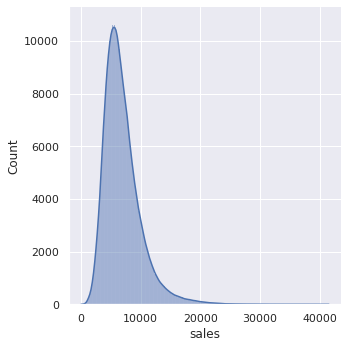

In [163]:
sns.displot(df4['sales'], kde=True);


### 4.1.2 Variáveis Numéricas

In [164]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

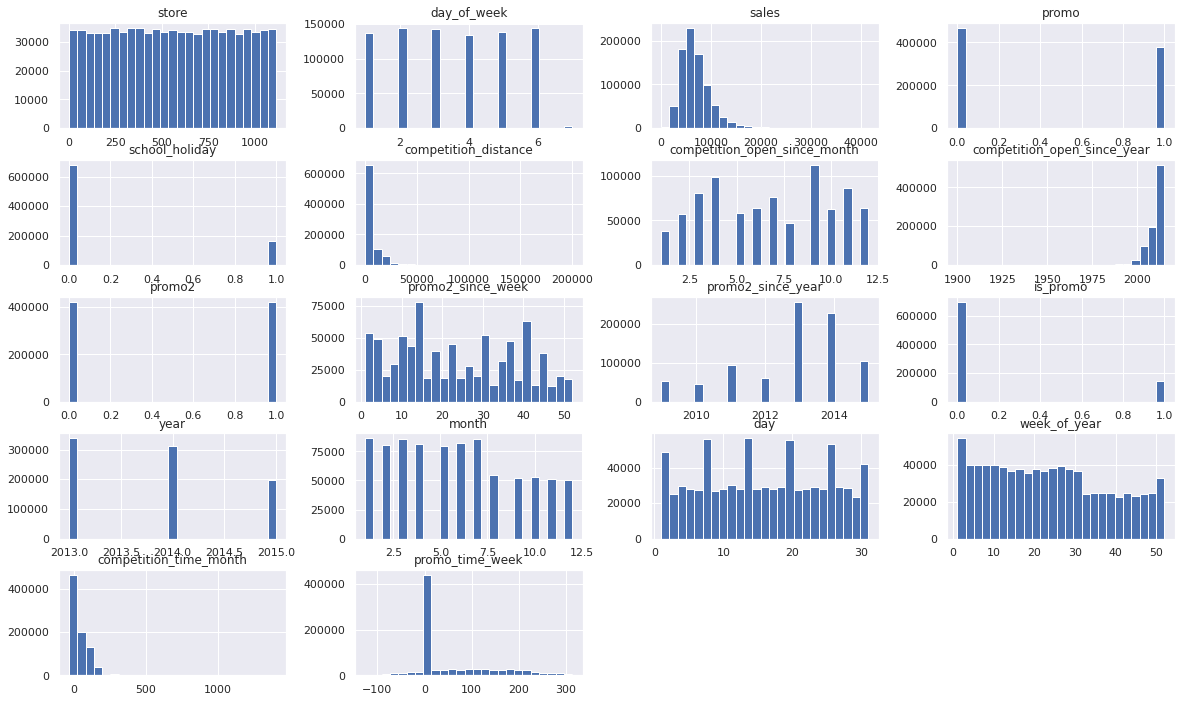

In [180]:
num_attributes.hist(bins=25);

### 4.1.3 Variáveis Categóricas

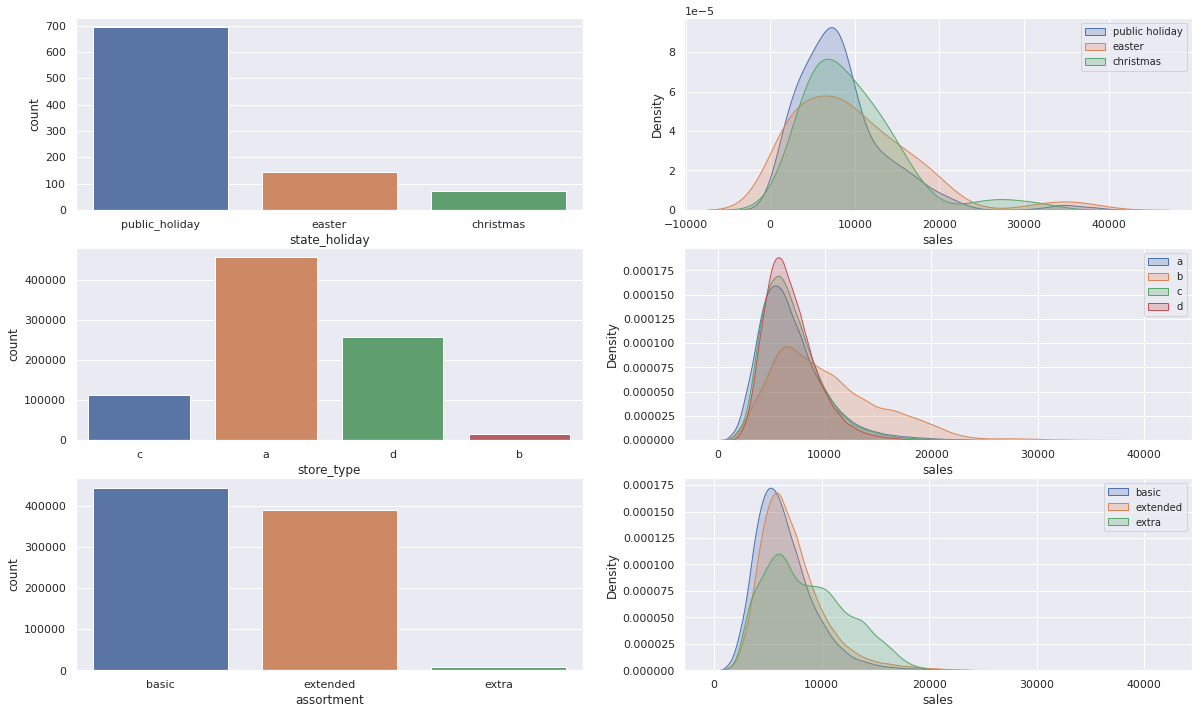

In [175]:
sns.set_theme()
plt.rcParams['figure.figsize'] = [20, 12]
# state holiday

plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']['state_holiday']
sns.countplot(x=a);

plt.subplot(3, 2, 2)
b = df4[df4['state_holiday'] == 'public_holiday']['sales']
sns.kdeplot(b, shade=True);


b = df4[df4['state_holiday'] == 'easter']['sales']
sns.kdeplot(b, shade=True);


b = df4[df4['state_holiday'] == 'christmas']['sales']
sns.kdeplot(b, shade=True);

plt.legend(labels=['public holiday', 'easter', 'christmas'], fontsize=10)
            
# store type
plt.subplot(3, 2, 3)
a = df4['store_type']
sns.countplot(x=a);

plt.subplot(3, 2, 4)
b = df4[df4['store_type'] == 'a']['sales']
sns.kdeplot(b, shade=True);

b = df4[df4['store_type'] == 'b']['sales']
sns.kdeplot(b, shade=True);

b = df4[df4['store_type'] == 'c']['sales']
sns.kdeplot(b, shade=True);

b = df4[df4['store_type'] == 'd']['sales']
sns.kdeplot(b, shade=True);

plt.legend(labels=['a', 'b', 'c', 'd'], fontsize=10)      


# assortment
plt.subplot(3, 2, 5)
a = df4['assortment']
sns.countplot(x=a);

plt.subplot(3, 2, 6)
b = df4[df4['assortment'] == 'basic']['sales']
sns.kdeplot(b, shade=True);

b = df4[df4['assortment'] == 'extended']['sales']
sns.kdeplot(b, shade=True);

b = df4[df4['assortment'] == 'extra']['sales']
sns.kdeplot(b, shade=True);

plt.legend(labels=['basic', 'extended', 'extra'], fontsize=10) 

## 4.2 Análise Bivariada

### 4.2.1 Análise das Hipóteses

#### 4.2.1.1 H1. Lojas com maior sortimentos deveriam vender mais.
**Verdadeiro.** Lojas com maior sortimento vendem mais, na média.

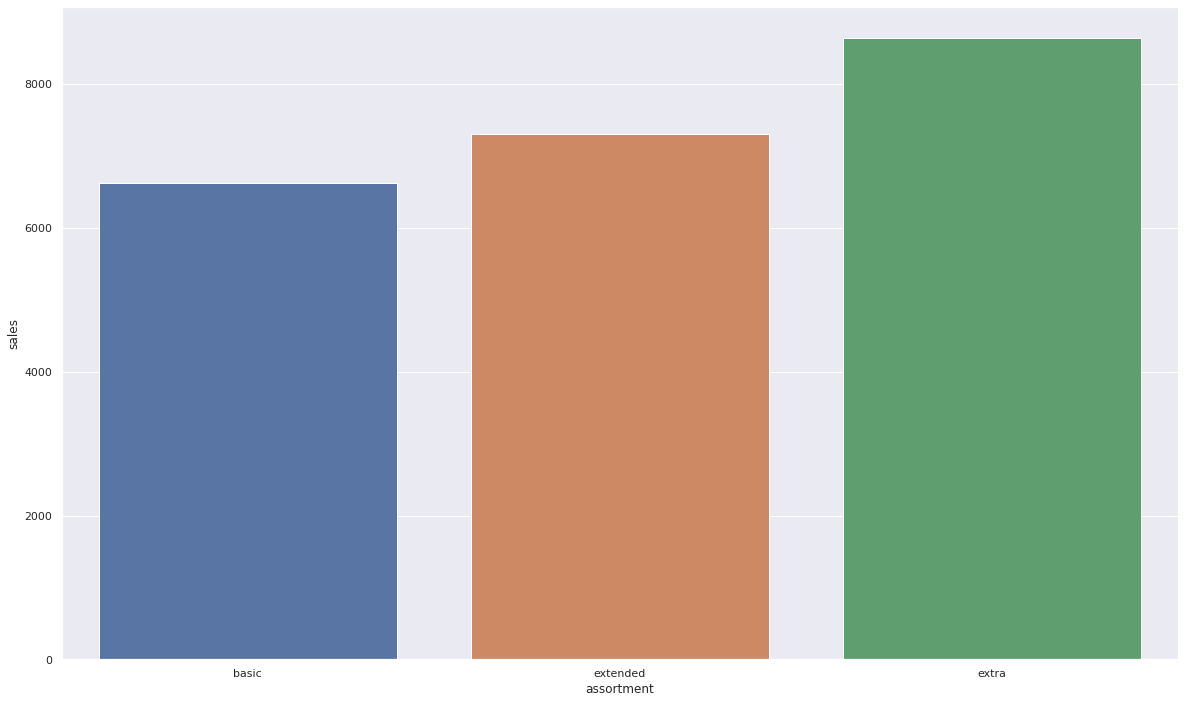

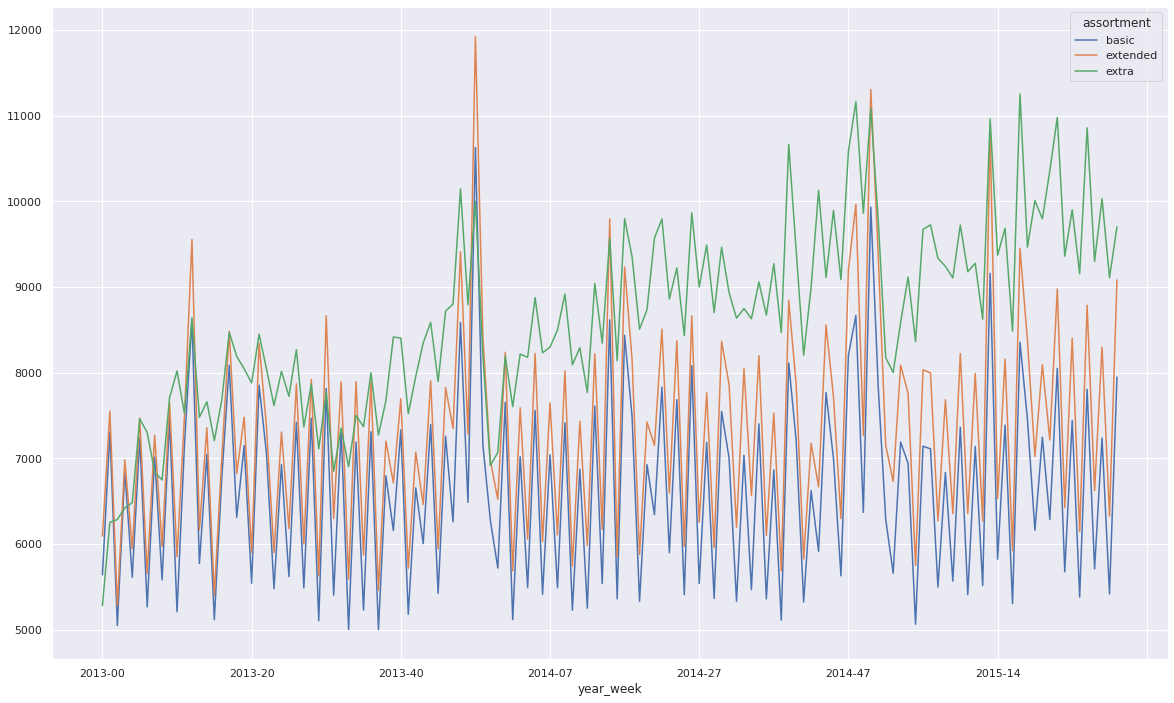

In [9]:
# assortment x sales
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).mean().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

In [24]:
aux3.head()

assortment,year_week,basic,extended,extra
0,2013-00,13434262,12425669,269404
1,2013-01,26007250,22917693,350279
2,2013-02,17970974,16029584,377207
3,2013-03,24392076,21243431,404662
4,2013-04,19972891,18130077,363061


#### 4.2.1.2 H2. Lojas com competidores mais próximos deveriam vender menos.
**Inconclusivo.** Não há um padrão na vendas entre lojas com competidores mais próximos ou mais distantes.

<AxesSubplot:>

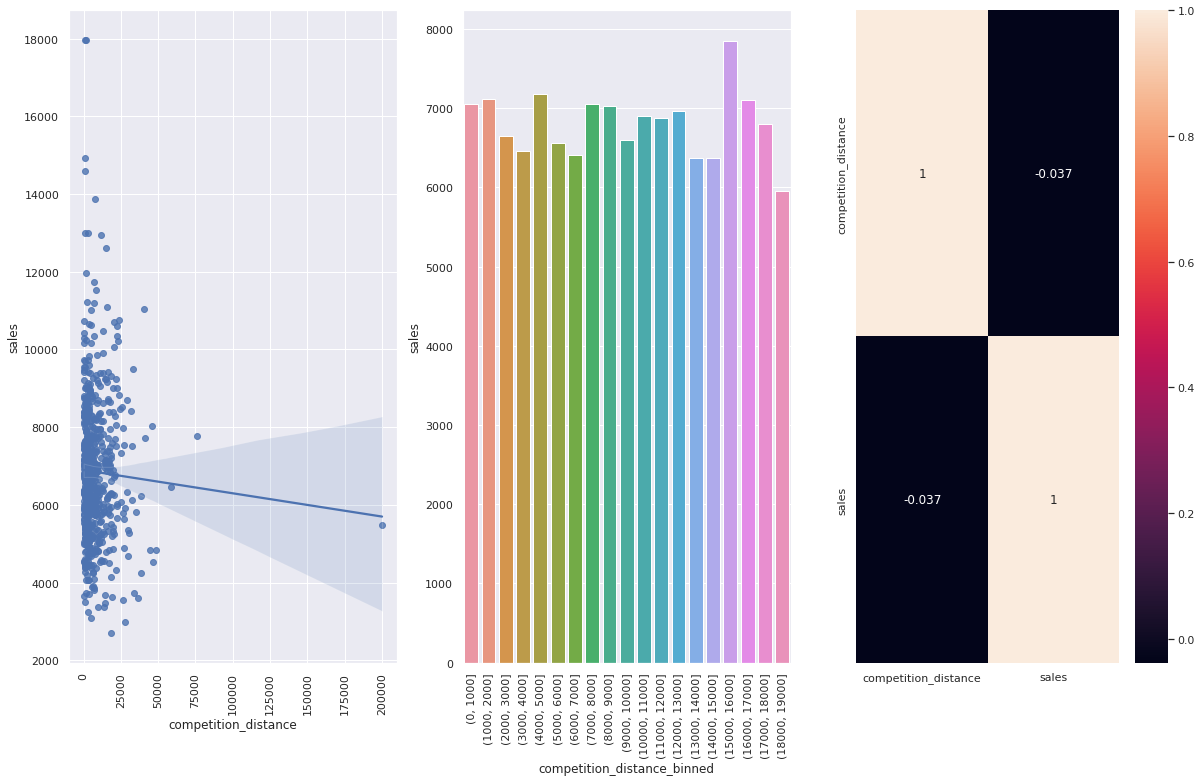

In [116]:
# competition_distance x sales
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

plt.subplot(1, 3, 1)
sns.regplot(data=aux1, x='competition_distance', y='sales')
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
b = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=b)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').mean().reset_index()
sns.barplot(data=aux2, x='competition_distance_binned', y='sales')
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)



#### 4.2.1.3 H3. Lojas com competidores à mais tempo deveriam vendem mais
**Falso.** Lojas com competidores à mais tempo vendem menos.

<AxesSubplot:>

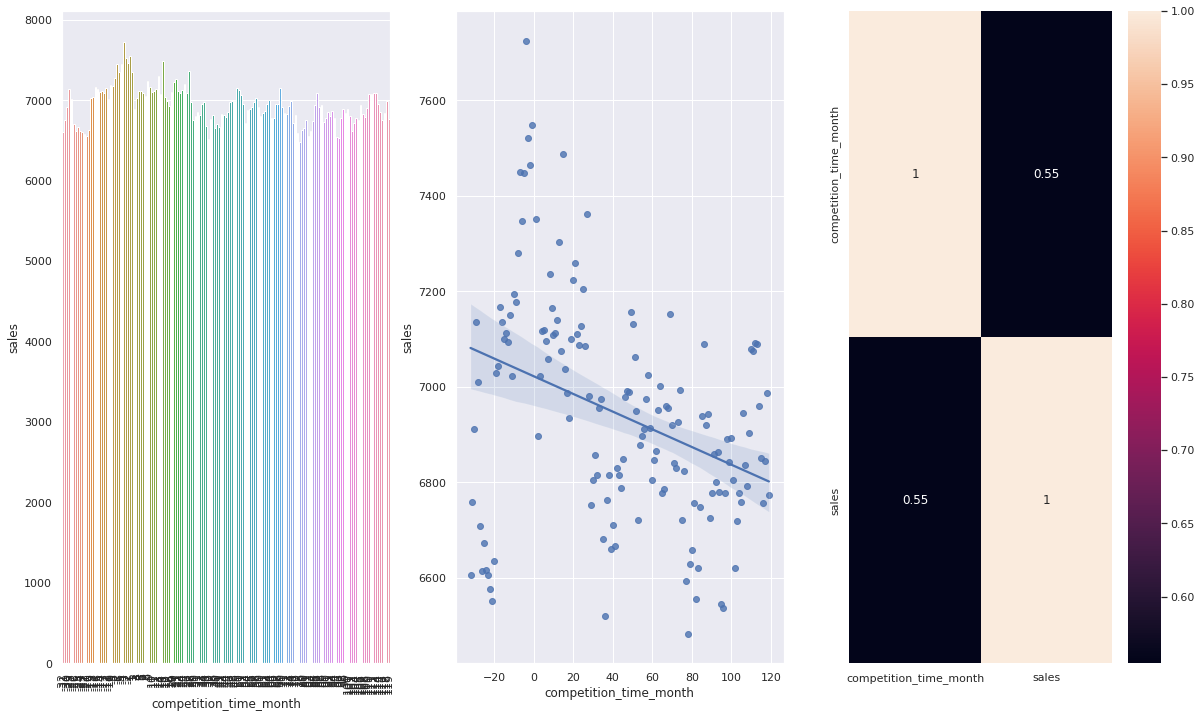

In [15]:
# competition_open_since_month x sales   
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').mean().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

plt.subplot(1, 3, 1)
sns.barplot(data=aux2, x='competition_time_month', y='sales')
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(data=aux2, x='competition_time_month', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

#### 4.2.1.4 **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.  
**Verdadeiro.** Lojas com promoções ativas por mais tempo vendem mais, na média.

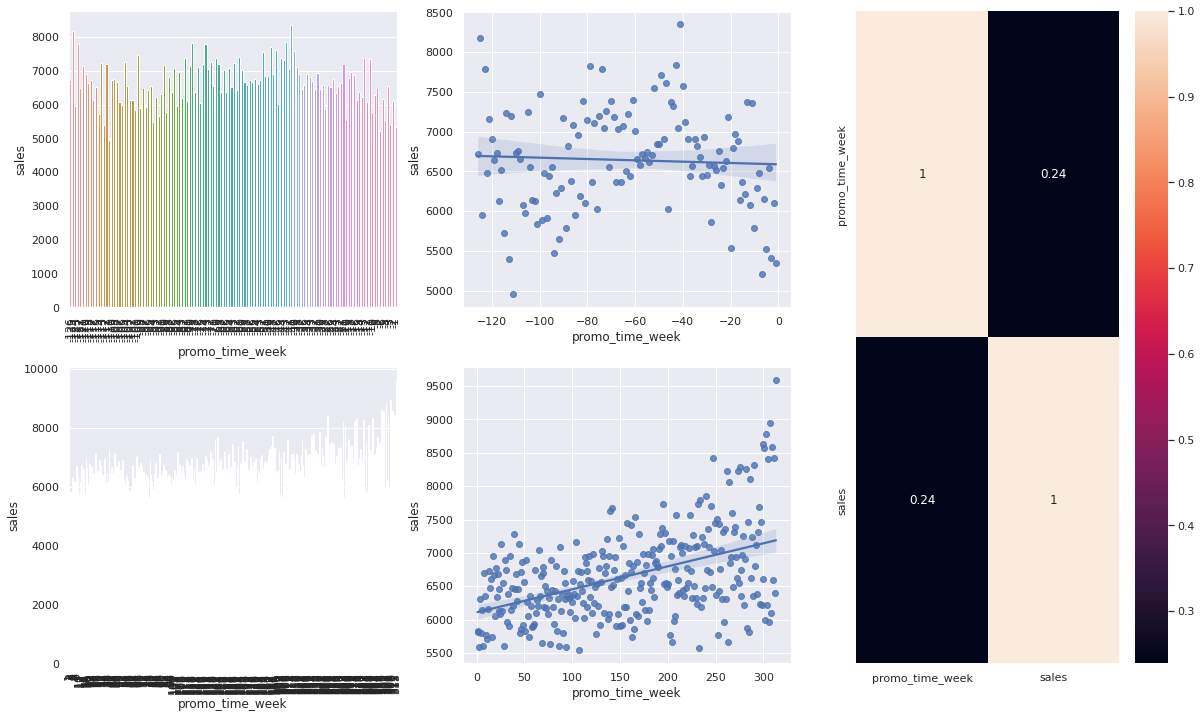

In [18]:
# promo_time_week x sales
aux = df4[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

aux1 = df4[df4['promo_time_week'] < 0]
aux2 = df4[df4['promo_time_week'] > 0]

aux3 = aux1[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()
aux4 = aux2[['promo_time_week', 'sales']].groupby('promo_time_week').mean().reset_index()

grid = GridSpec(2, 3)

plt.subplot(grid[0,0])
sns.barplot(data=aux3, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(data=aux3, x='promo_time_week', y='sales');

plt.subplot(grid[1,0])
sns.barplot(data=aux4, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(data=aux4, x='promo_time_week', y='sales');

plt.subplot(grid[:,2])
sns.heatmap(aux.corr(method='pearson'), annot=True);

#### 4.2.1.5 **H5.** Lojas com mais dias de promoção deveriam vender mais.
Deixaremos a validação dessa hipótese para a próxima etapa no cilco do GRISP.

#### 4.2.1.6 **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Falso.** Lojas com mais promoções consecutivas vendem menos.

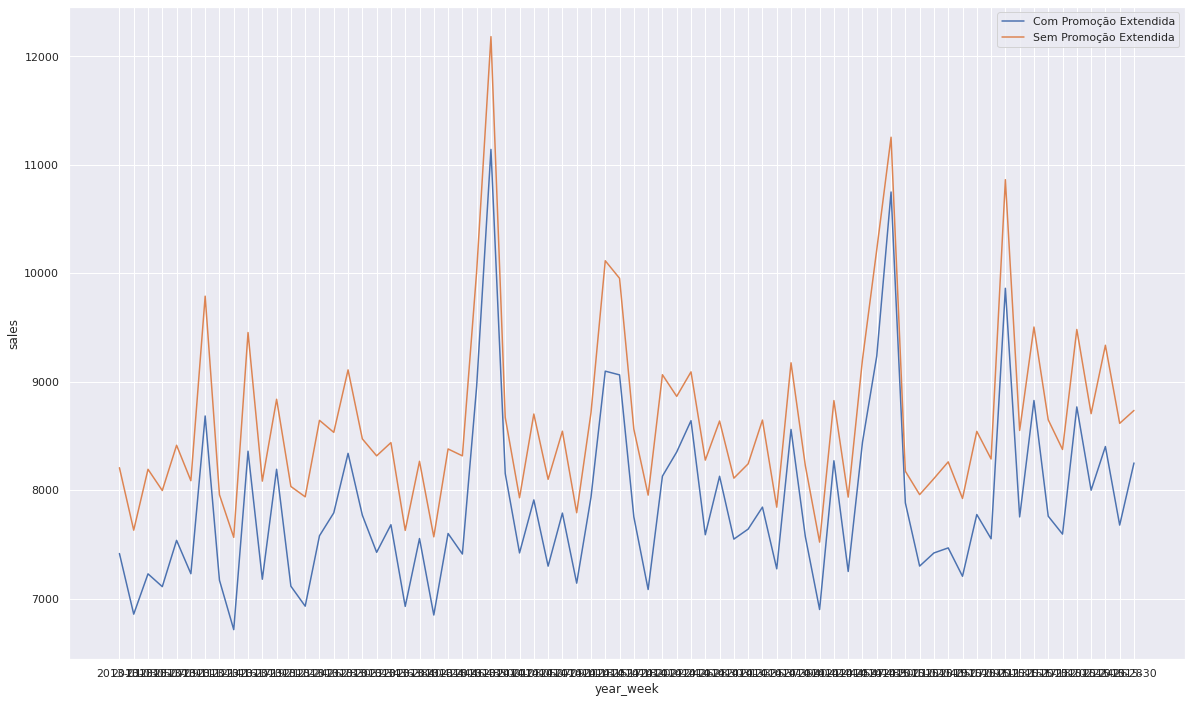

In [117]:
# promo x promo2 x sales
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).mean().reset_index()

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
sns.lineplot(data=aux1, x='year_week', y='sales')

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').mean().reset_index()
sns.lineplot(data=aux2, x='year_week', y='sales')

plt.legend(labels=['Com Promoção Extendida', 'Sem Promoção Extendida'])

#### 4.2.1.7 **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**Verdadeiro.** Lojas vendem, na média, mais durante o feriado de Natal e de Páscoa.

<AxesSubplot:xlabel='year', ylabel='sales'>

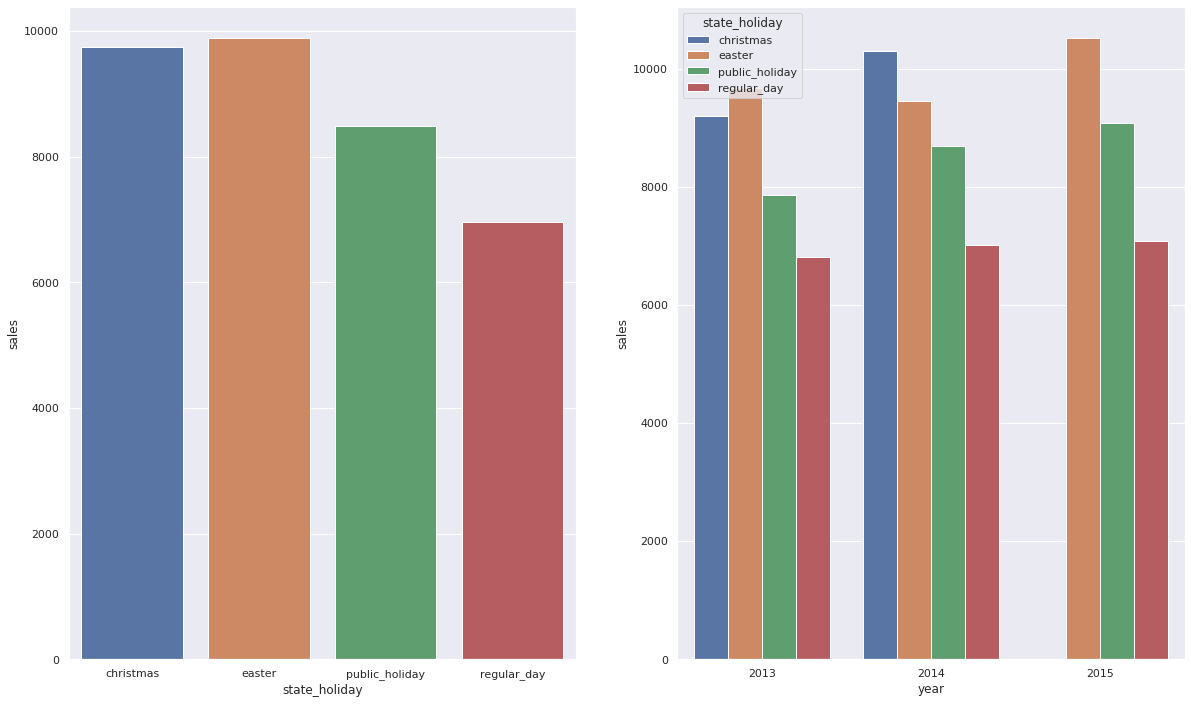

In [49]:
# state_holiday x sales
aux = df4[['state_holiday', 'sales']].groupby('state_holiday').mean().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(data=aux, x='state_holiday', y='sales');

plt.subplot(1, 2, 2)
aux2 = df4[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).mean().reset_index()
sns.barplot(data=aux2, x='year', y='sales', hue='state_holiday')


In [45]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

#### 4.2.1.8 **H8.** Lojas deveriam vender mais ao longo dos anos.
**Inconclusivo.** O ano de 2015 não está fechado, assim só podemos analisar a diferença entre 2013 e 2014, quando houve uma queda nas vendas.

<AxesSubplot:>

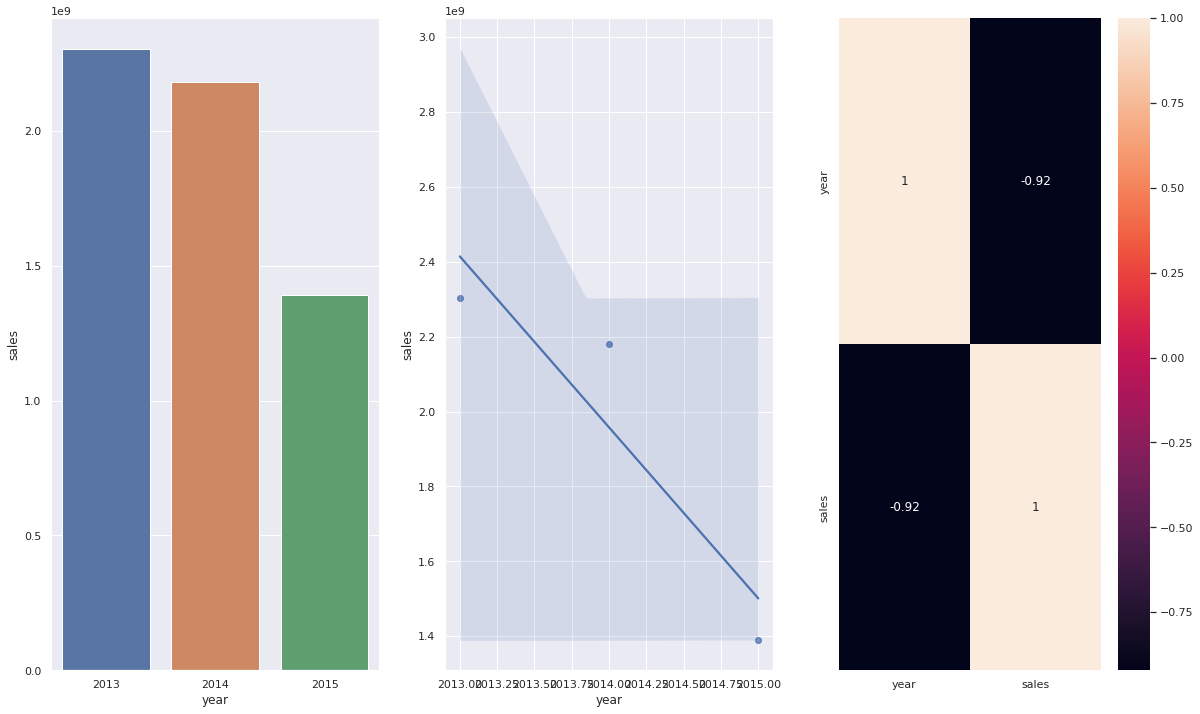

In [52]:
# year x sales
aux = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data=aux, x='year', y='sales')

plt.subplot(1, 3, 2)
sns.regplot(data=aux, x='year', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

#### 4.2.1.9 **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**Verdadeiro.** Lojas vendem mais no segundo semestre.

<AxesSubplot:xlabel='semestre', ylabel='sales'>

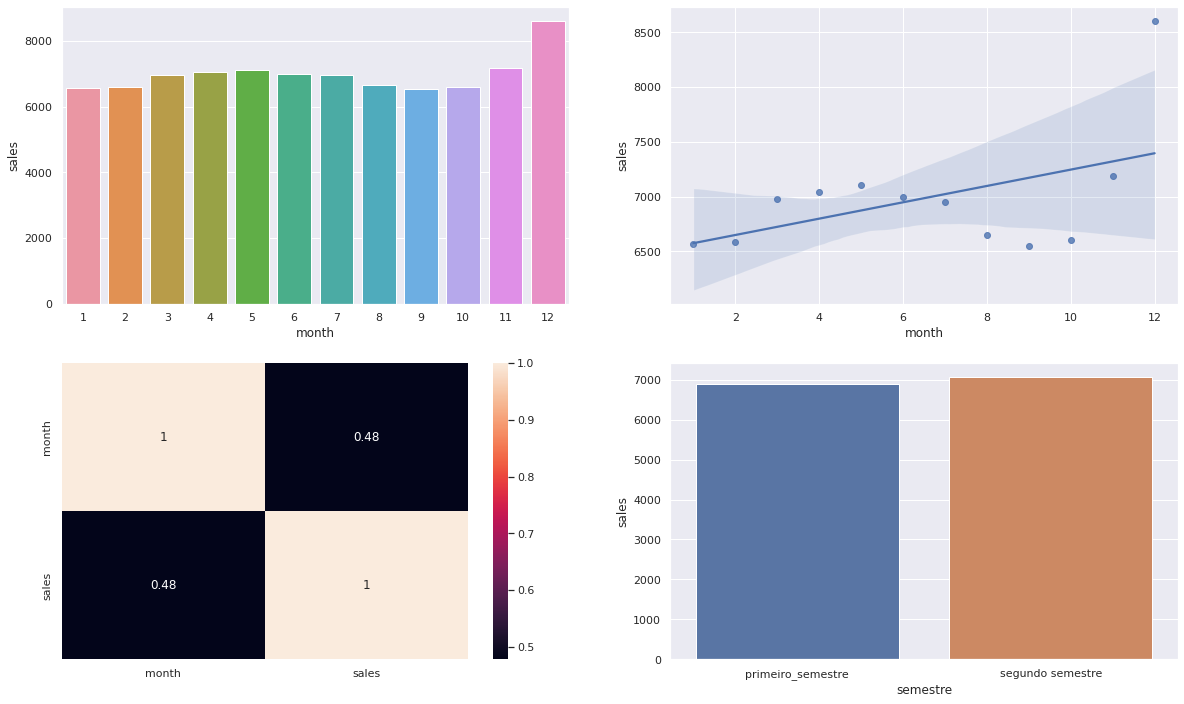

In [126]:
# month x sales
aux1 = df4[['month', 'sales']].groupby('month').mean().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(data=aux1, x='month', y='sales')

plt.subplot(2, 2, 2)
sns.regplot(data=aux1, x='month', y='sales')

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

plt.subplot(2, 2, 4)
aux2 = df4.copy()
aux2['semestre'] = aux2['month'].apply(lambda x: 'primeiro_semestre' if x <= 6 else 'segundo semestre')
aux3 = aux2[['semestre', 'sales']].groupby('semestre').mean().reset_index()
sns.barplot(data=aux3, x='semestre', y='sales')

#### 4.2.1.10 **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**Falso.** Na média, os dias que antecedem o dia 10 de cada mês vendem mais.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

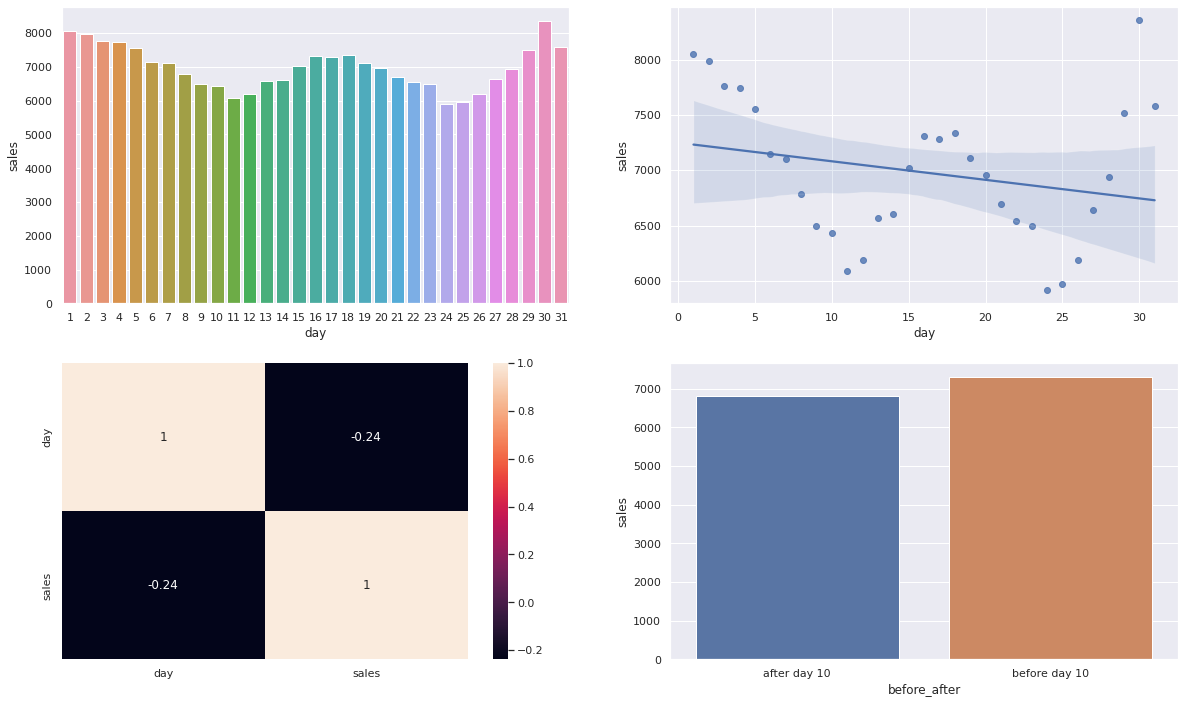

In [127]:
# day x sales
aux = df4[['day', 'sales']].groupby('day').mean().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(data=aux, x='day', y='sales')

plt.subplot(2, 2, 2)
sns.regplot(data=aux, x='day', y='sales')

plt.subplot(2, 2, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

plt.subplot(2, 2, 4)
aux['before_after'] = aux['day'].apply(lambda x: 'before day 10' if x <= 10 else 'after day 10')
aux1 = aux[['before_after', 'sales']].groupby('before_after').mean().reset_index()

sns.barplot(data=aux1, x='before_after', y='sales')

#### 4.2.1.11 **H11.** Lojas deveriam vender menos aos finais de semana.
**Verdadeiro.** Lojas vendem menos nos finais de semana.

<AxesSubplot:>

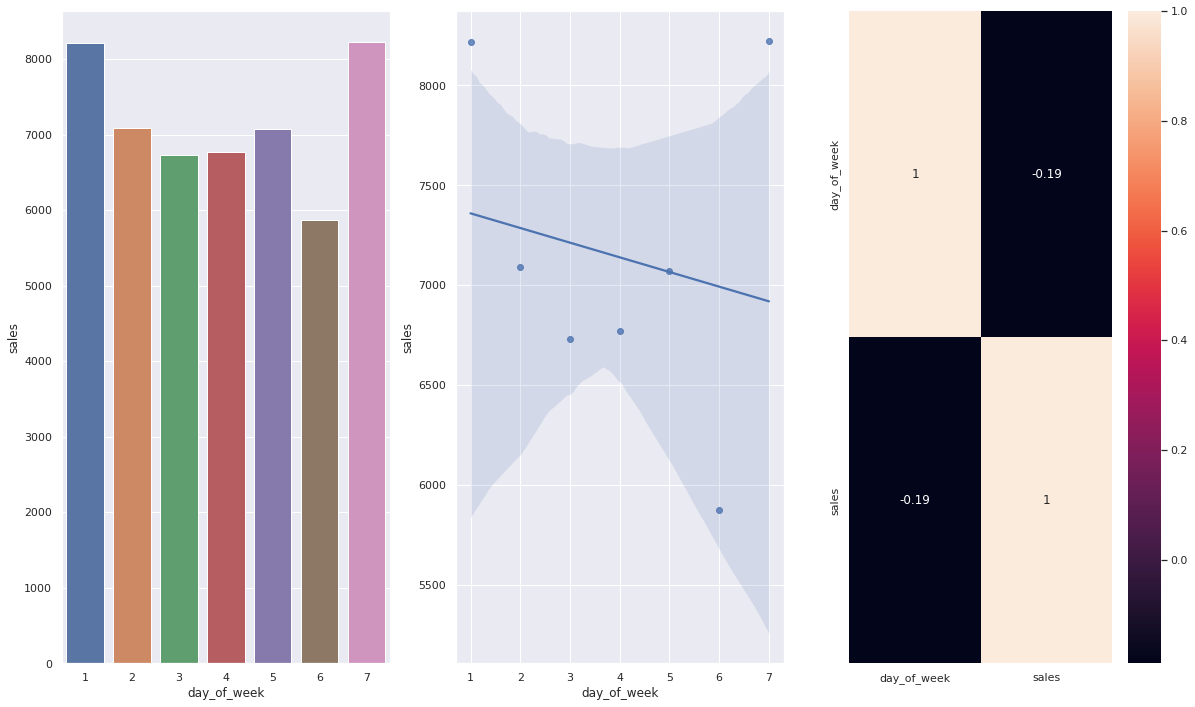

In [157]:
# day_of_week x sales
# analisando todas as lojas
aux = df4[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data=aux, x='day_of_week', y='sales')

plt.subplot(1, 3, 2)
sns.regplot(data=aux, x='day_of_week', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True)


<AxesSubplot:>

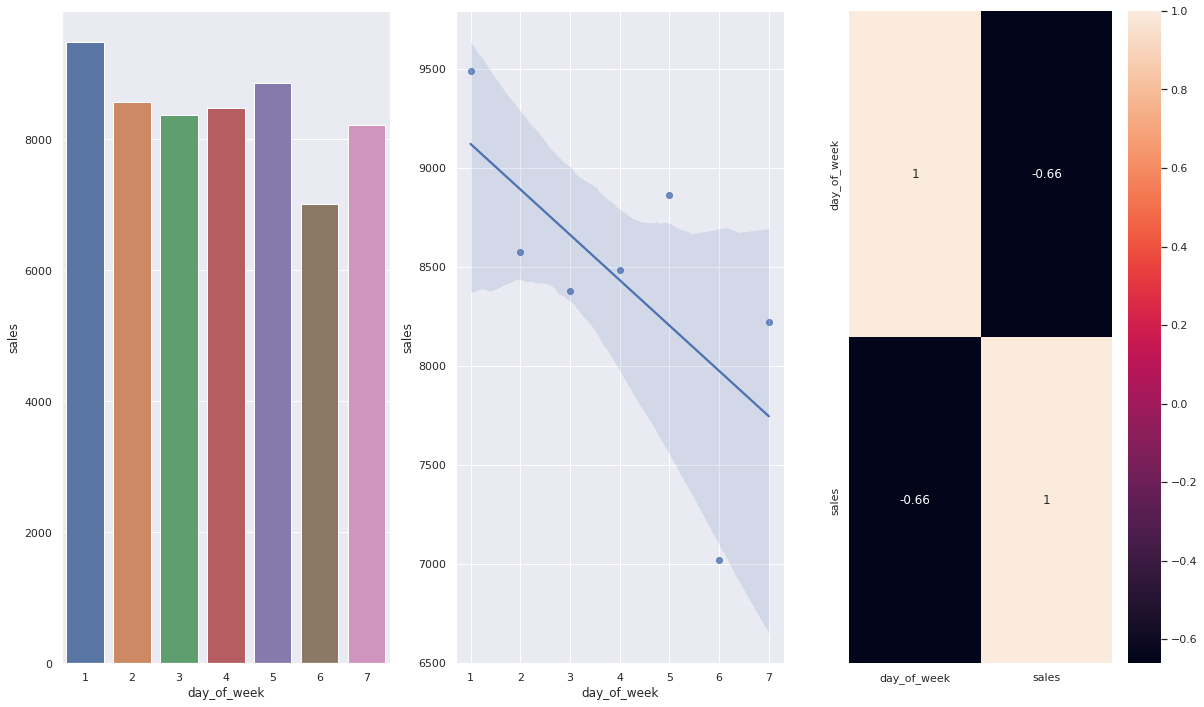

In [158]:
# analisando apenas as lojas que abrem aos domingos
store_list = list(df4.loc[df4['day_of_week'] == 7, ['store', 'sales']]['store'].unique())

aux1 = df4.loc[df4['store'].isin(store_list)]

aux = aux1[['day_of_week', 'sales']].groupby('day_of_week').mean().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(data=aux, x='day_of_week', y='sales')

plt.subplot(1, 3, 2)
sns.regplot(data=aux, x='day_of_week', y='sales')

plt.subplot(1, 3, 3)
sns.heatmap(aux.corr(method='pearson'), annot=True)

#### 4.2.1.12 **H12.** Lojas deveriam vender menos durante os feriados escolares.
**Falso.** Na média, lojas vendem mais durante os feriados escolares, com exceção dos meses de setembro e dezembro.

<AxesSubplot:xlabel='month', ylabel='sales'>

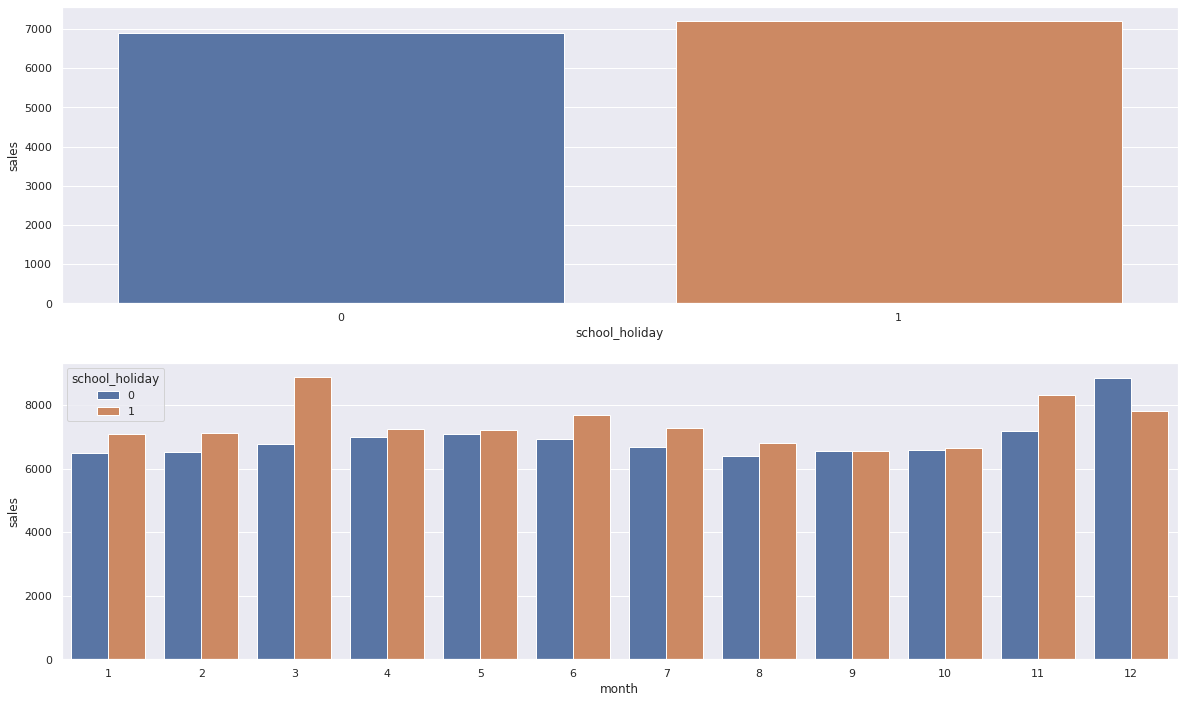

In [91]:
# schooll_holischool_holiday x sales
aux = df4[['school_holiday', 'sales']].groupby('school_holiday').mean().reset_index()

plt.subplot(2, 1, 1)
sns.barplot(data=aux, x='school_holiday', y='sales')

plt.subplot(2, 1, 2)
aux1 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).mean().reset_index()
sns.barplot(data=aux1, x='month', y='sales', hue='school_holiday')


#### 4.1.2.13 Resumo das Hipóteses

| Hipótese | Veracidade | Relevância |
|----------|------------|------------|
|H1        |Falso       |Alta        |
|H2        |Inconclusivo|Baixa       |
|H3        |Falso       |Alta        |
|H4        |Verdadeiro  |Alta        |
|H5        |            |            |
|H6        |Falso       |Baixa       |
|H7        |Verdadeira  |Média       |
|H8        |Inconclusivo|            |
|H9        |Verdadeiro  |Média       |
|H10       |Falso       |Alta        |
|H11       |Verdadeiro  |Alta        |
|H12       |Falso       |Baixa       |

## 4.3 Análise Multivariada

### 4.3.1 Atributos Numéricos

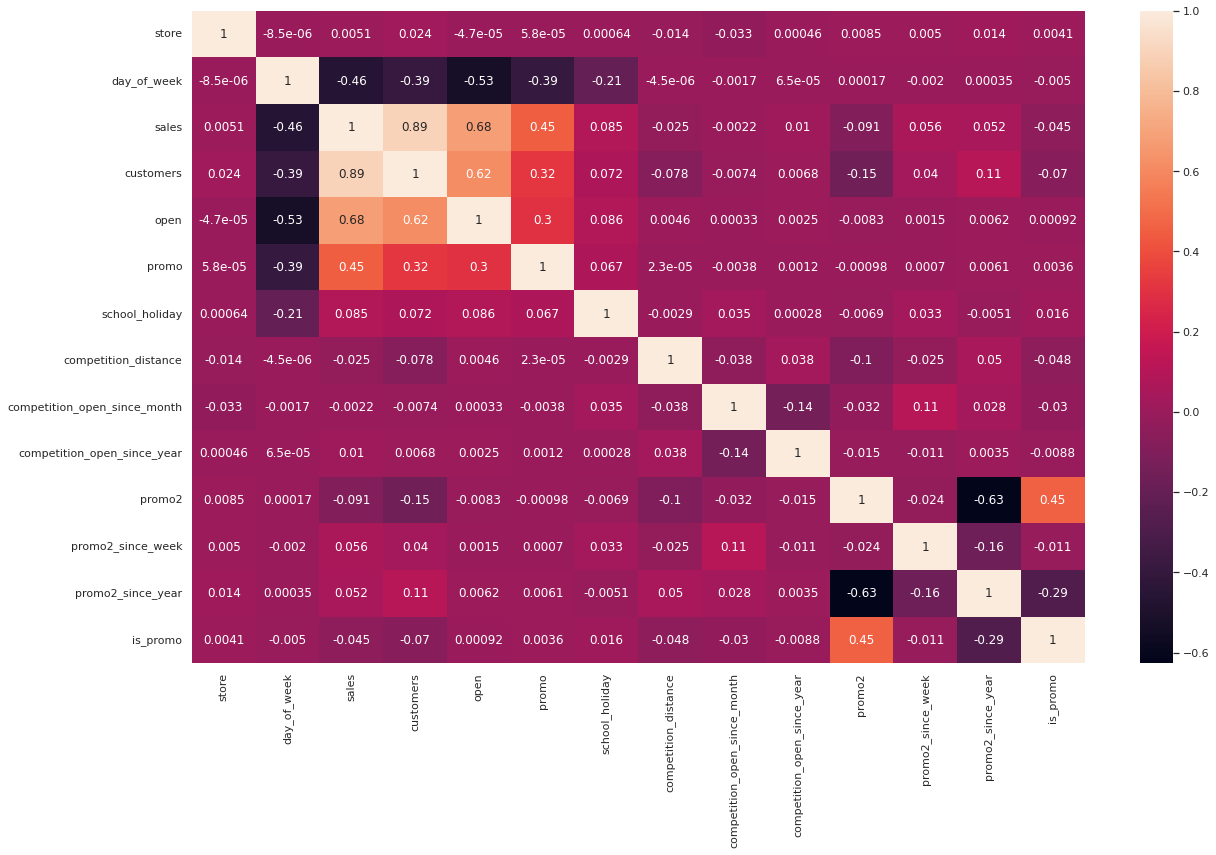

In [108]:
num_attributes = df2.select_dtypes(include=['int64', 'float64'])

sns.heatmap(num_attributes.corr(method='pearson'), annot=True);

### 4.3.2 Atributos Categóricos

Para analisarmos a correlação entre as variáveis categóricas, utilizaremos calcularemos o Cramer V que é baseado no teste qhi-quadrado de Pearson. O Cramer V é um número entre 0 e 1, quanto mais próximo de 1, maior é a correlação entre as variáveis. O cálculo é feito com a seguinte fórmula:
$$V = \sqrt{\frac{\chi ^2 / n}{\min(k-1, r-1)}}$$
onde
- $\chi$ é devirado do teste qui-quadrado de Pearson;
- $n$ é o número total de observações;
- $k$ é o número de colunas;
- $r$ é o número de linhas.

Porém, utilizar esse cálculo pode gerar um resultado superestimado, para correção do viés calcularemos:
$$\tilde{V}=\sqrt{\frac{\tilde{\phi} ^2}{\min(\tilde{k}-1, \tilde{r}-1)}}$$
onde

$\tilde{\phi} ^2 = \max \left(0, \frac{\chi ^2}{n}-\frac{(k-1)(r-1)}{(n-1)}\right)$

$\tilde{k} = k - \frac{(k-1)^2}{(n-1)}$

$\tilde{r} = r - \frac{(r-1)^2}{(n-1)}$


<AxesSubplot:>

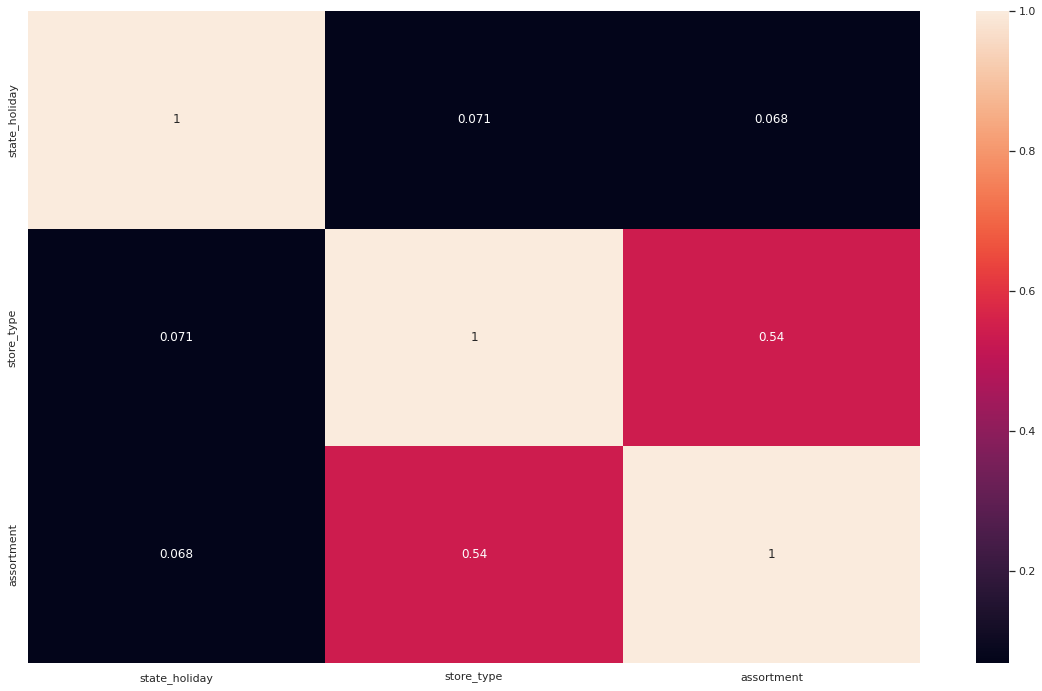

In [143]:
cat = df4.select_dtypes(include=['object'])

cat_list = ['state_holiday', 'store_type', 'assortment']
cat_dic = {}

for c1 in cat_list:
    for c2 in cat_list:
        v = cramer_v(cat[c1], cat[c2])
        
        if cat_list.index(c2) == 0:
            cat_dic[c1] = []
            cat_dic[c1].append(v)
            
        else:
            cat_dic[c1].append(v)

cramer_v_table = pd.DataFrame(cat_dic)
cramer_v_table.set_index(cramer_v_table.columns, inplace=True)

sns.heatmap(cramer_v_table, annot=True)

# 5 Preparação dos Dados

In [8]:
df5 = df4.copy()

## 5.1 Normalização

A normalização reescala os dados para um intervalo com média 0 e desvio padrão 1, ou seja, para valores entre -1 e 1. Utilizamos ela para dados normalmente distribuídos (Gaussianos).

Analisando os dados da sessão 4.1.2, podemos observar que não há nenhuma distribuição normal. Portanto, não utilizaremos a Normalização nesse projeto.

## 5.2 Rescaling

O Rescaling, assim como a Normalização, também reescala os dados porém para um intervalo entre 0 e 1. Além disso é recomendado para distruições não-Gaussianas.

In [9]:
# selecinando as variáveis numéricas
df5.select_dtypes(include=['int64', 'float64']).head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.00000,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.00000,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.00000,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.00000,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.00000,4,2015,0,31,2015,0,2015,7,31,31,4,0


<AxesSubplot:>

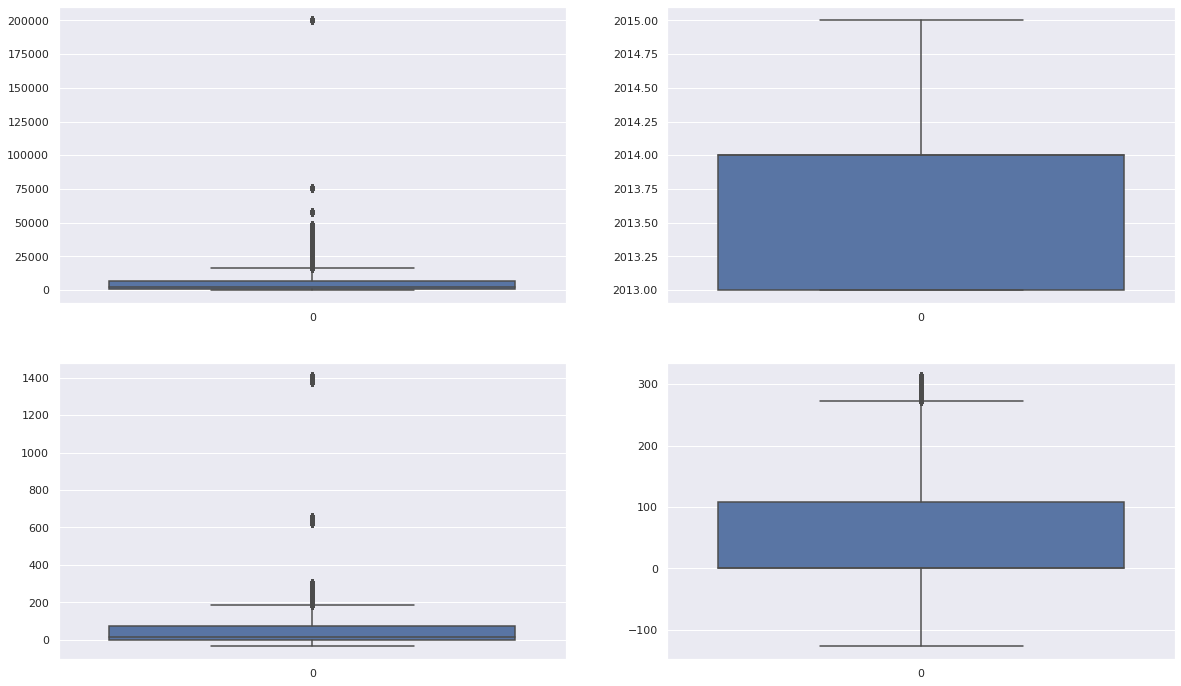

In [10]:
# BOXPLOT 
plt.subplot(2, 2, 1)
sns.boxplot(data=df5['competition_distance'])

plt.subplot(2, 2, 2)
sns.boxplot(data=df5['year'])

plt.subplot(2, 2, 3)
sns.boxplot(data=df5['competition_time_month'])

plt.subplot(2, 2, 4)
sns.boxplot(data=df5['promo_time_week'])

In [10]:
# variáveis não cíclicas
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance (analisando o boxplot vemos que possui muitos valores atípicos (outliers), 
#                       então vamos utilizar o RobustScaler)
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']])
    
# year (analisando o boxplot vemos que não possui muitos valores atípicos, 
#       então vamos utilizar o MinMaxScaler)
df5['year'] = mms.fit_transform(df5[['year']])

# competiton_time_month (analisando o boxplot vemos que possui muitos valores atípicos (outliers), 
#                        então vamos utilizar o RobustScaler)
df5['competition_time_month'] = rs.fit_transform(df5[['competition_distance']])

# promo_time_week (analisando o boxplot vemos que não possui muitos valores atípicos, 
#                  então vamos utilizar o MinMaxScaler)
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']])
    

## 5.3 Transformação

### 5.3.1 Encoding

Encoding são métodos utlizados para transformar variáveis categóricas em variáveis numéricas. Existem várias maneiras, aqui utilizaremos três delas: 'One Hot Encoding', 'Label Encoding' e 'Ordinal Encoding'. Essa será nossa primeira tentativa, na próxima etapa do CRISP analisamos se é necessária a troca do método de Encoding. 

- **One Hot Encoding**: transforma a variáveis númerica em zeros (0) e uns (1), que representam, respectivamente, 'não' e 'sim'.
- **Label Encoding**: enumera cada valor categórico com um número 'aleatório'.
- **Ordinal Encoding**: enumero cada valor categórico com um número, mas de forma ordenada. Para isso a variáveis categórica deve ser ordinal, assim o menor valor recebe 1, o segundo menor recebe 2 e assim por diante.

Referência: https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

In [11]:
df5.select_dtypes(include=['object'])

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30
...,...,...,...,...
1016776,public_holiday,b,basic,2013-00
1016827,public_holiday,b,extra,2013-00
1016863,public_holiday,b,extra,2013-00
1017042,public_holiday,b,extra,2013-00


In [12]:
# state holiday (One Hot Encoding)
df5 = pd.get_dummies(data=df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type (Label Encoding)
df5['store_type'] = LabelEncoder().fit_transform(df5['store_type'])

# assortment (Ordinal Encoding, basic = 1, extra = 2, extended = 3)
assortment_dic = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dic)


In [14]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.17097,9,...,31,2015-30,2008-09-01,-0.17097,2015-07-27,0.28702,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.28387,11,...,31,2015-30,2007-11-01,-0.28387,2010-03-22,0.92255,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.90323,12,...,31,2015-30,2006-12-01,1.90323,2011-03-28,0.80182,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.27581,9,...,31,2015-30,2009-09-01,-0.27581,2015-07-27,0.28702,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.44839,4,...,31,2015-30,2015-04-01,4.44839,2015-07-27,0.28702,0,0,0,1


### 5.3.2 Transformação da Variável Resposta

Os métodos de transformação tem como objetivo transformação a distribuição da variável em uma distribuição normal (ou pelo menos, que se assemelhe a uma Gaussiana).

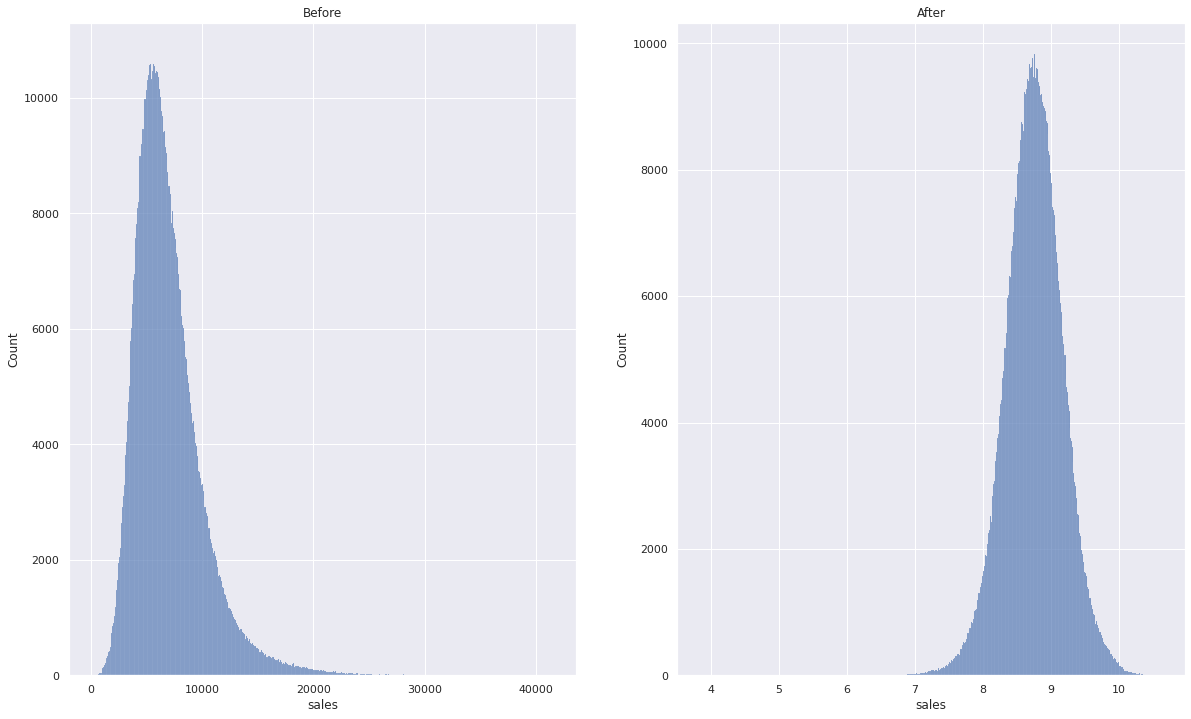

In [13]:
# Tranformação Logarítmica

# antes
plt.subplot(1, 2, 1)
a = sns.histplot(data=df5['sales']);
a.set_title('Before');

plt.subplot(1, 2, 2)
df5['sales'] = np.log1p(df5['sales']);
b = sns.histplot(data=df5['sales']);
b.set_title('After');

### 5.3.3 Transformação de Natureza Cíclica

Para variáveis de natureza cíclica (mês, dia do mês, dia da semana, etc.) faremos uma transformação trigonométrica fazendo um bijeção de cada valor da variável a um ponto da circunferência trigonométrica, assim, garantimos que a periodicidade será mantida. 

In [14]:
# variáveis cíclicas
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*2*np.pi/7))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*2*np.pi/7))
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*2*np.pi/12))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*2*np.pi/12))
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*2*np.pi/30))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*2*np.pi/30))
# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*2*np.pi/52))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*2*np.pi/52))

# 6 Seleção de Atributos

Para a seleção dos atributos aplicaremos o algorítmo Boruta.

In [15]:
df6 = df5.copy()

In [18]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.56865,1,1,2,1,-0.17097,9,...,0,1,0.50000,-0.86603,-0.50000,-0.86603,-0.50000,-0.86603,-0.50000,-0.86603
1,2,5,2015-07-31,8.71029,1,1,0,1,-0.28387,11,...,0,1,0.50000,-0.86603,-0.50000,-0.86603,-0.50000,-0.86603,-0.50000,-0.86603
2,3,5,2015-07-31,9.02582,1,1,0,1,1.90323,12,...,0,1,0.50000,-0.86603,-0.50000,-0.86603,-0.50000,-0.86603,-0.50000,-0.86603
3,4,5,2015-07-31,9.54653,1,1,2,3,-0.27581,9,...,0,1,0.50000,-0.86603,-0.50000,-0.86603,-0.50000,-0.86603,-0.50000,-0.86603
4,5,5,2015-07-31,8.48115,1,1,0,1,4.44839,4,...,0,1,0.50000,-0.86603,-0.50000,-0.86603,-0.50000,-0.86603,-0.50000,-0.86603


## 6.1 Separação do Dataframe: treino e teste

In [19]:
df6.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'school_holiday',
       'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week',
       'state_holiday_christmas', 'state_holiday_easter',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos'],
      dtype='object')

In [17]:
# deletar as colunas que não utilizaremos.
cols_drop = ['day_of_week', 'month', 'day', 'week_of_year', 'promo_since', 'competition_since', 'year_week']    

df6 = df6.drop(cols_drop, axis=1)

df6.columns

Index(['store', 'date', 'sales', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'is_promo', 'year', 'competition_time_month',
       'promo_time_week', 'state_holiday_christmas', 'state_holiday_easter',
       'state_holiday_public_holiday', 'state_holiday_regular_day',
       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos'],
      dtype='object')

Como a predição será feita para seis semanas, separaremos o dataframe da seguinte maneira:
- do início até o começo das seis últimas semanas será destinado para o treino do modelo
- as últimas seis semanas para teste.

In [21]:
# data máxima - seis semanas
df6['date'].max() - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [22]:
# conjunto de dados de treino
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# conjunto de dados de teste
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Data mínima do Treino {}'.format(x_train['date'].min()))
print('Data máxima do Treino {}\n'.format(x_train['date'].max()))

print('Data mínima do Teste {}'.format(x_test['date'].min()))
print('Data máxima do Teste {}'.format(x_test['date'].max()))

Data mínima do Treino 2013-01-01 00:00:00
Data máxima do Treino 2015-06-18 00:00:00

Data mínima do Teste 2015-06-19 00:00:00
Data máxima do Teste 2015-07-31 00:00:00


## 6.2 Boruta para seleção de atributos

In [23]:
# conjunto de dados de treino e teste
x_train_n = x_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values

# define random forest regressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)

KeyboardInterrupt: 

In [ ]:
cols_selected_boruta = list(x_train.drop(['date', 'sales'], axis=1).loc[:, list(boruta.support_)].columns)

In [ ]:
# Ranking dos Atributos
a = list(x_train.drop(['date', 'sales'], axis=1).columns)
r = boruta.ranking_

pd.DataFrame(r, index=a, columns=['Rank'])

## 6.3 Seleção Manual dos Atributos

In [16]:
cols_selected_boruta = ['store',
 'promo',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'store_type',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos']

# cols_selected_boruta.extend(['date', 'sales'])

cols_not_selected_boruta = list(df6.columns)
for i in cols_selected_boruta:
    cols_not_selected_boruta.remove(i)

In [17]:
cols_selected_boruta

['store',
 'promo',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'store_type',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos']

In [18]:
cols_not_selected_boruta

['day_of_week',
 'date',
 'sales',
 'school_holiday',
 'is_promo',
 'year',
 'month',
 'day',
 'week_of_year',
 'year_week',
 'competition_since',
 'promo_since',
 'state_holiday_christmas',
 'state_holiday_easter',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']

Analisando o rank dos atributos e a análise realizada na Seção 4, vamos acrescentar 'day_cos' e 'week_of_year_cos' nos atributos selecionados para o modelo.

In [19]:
cols_selected = cols_selected_boruta.copy()
cols_selected.extend(['day_cos', 'week_of_year_cos'])
cols_not_selected = cols_not_selected_boruta.copy()
cols_not_selected.remove('day_cos')
cols_not_selected.remove('week_of_year_cos')

In [20]:
cols_selected

['store',
 'promo',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'store_type',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_cos',
 'week_of_year_cos']

In [21]:
cols_not_selected

['day_of_week',
 'date',
 'sales',
 'school_holiday',
 'is_promo',
 'year',
 'month',
 'day',
 'week_of_year',
 'year_week',
 'competition_since',
 'promo_since',
 'state_holiday_christmas',
 'state_holiday_easter',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'month_sin',
 'day_sin',
 'week_of_year_sin']

# 7 Modelos de Machine Learning

Agora, vamos testar cinco modelos de Machine Learning e analisar qual deles tem a melhor performance.
- Modelo de Média
- Modelo de Regressão Linear
- Modelo de Regressão Linear Regularizado

In [22]:
df7 = df6.copy()

In [28]:
# recapitulando:
# conjunto de dados de treino
x_train = df7[df7['date'] < '2015-06-19']
y_train = x_train['sales']

# conjunto de dados de teste
x_test = df7[df7['date'] >= '2015-06-19']
y_test = x_test['sales']

# conjunto de dados de treino e teste apenas com as colunas selecionadas na Seção anterior
x_train = x_train[cols_selected]
x_test = x_test[cols_selected]


## 7.1 Modelo de Média

In [55]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'prediction'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['prediction']

# performance
baseline_result = ml_error('Modelo de Média', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Modelo,MAE,MAPE,RMSE
0,Modelo de Média,1354.80035,0.20640,1835.13554


## 7.2 Modelo de Regressão Linear

In [56]:
# modelo
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Regressão Linear', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Modelo,MAE,MAPE,RMSE
0,Regressão Linear,1870.49255,0.29500,2669.84806


## 7.3 Modelo de Regressão Linear Regularizado - Lasso

In [57]:
# modelo 
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Regressão Linear - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Modelo,MAE,MAPE,RMSE
0,Regressão Linear - Lasso,1894.69649,0.28906,2747.23590


## 7.4 Regressão 'Random Forest'

In [35]:
# modelo
rf = RandomForestRegressor(n_jobs=-1, random_state=5).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Regressão Random Forest', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Modelo,MAE,MAPE,RMSE
0,Regressão Random Forest,674.82056,0.10065,1009.43141


## 7.5 Regressão XGBoost  

In [37]:
# modelo
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100, 
                              max_depth=10, 
                              eta=0.1, 
                              subsample=0.7, 
                              colsample_bytree=0.9).fit(x_train, y_train)

# predicit
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('Regressão XGBoost', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Modelo,MAE,MAPE,RMSE
0,Regressão XGBoost,854.64452,0.12680,1242.52702


## 7.6 Comparação das Performances dos Modelos de Regressão

### 7.6.1 Perfomance de uma Única Parte

In [34]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

NameError: name 'lrr_result' is not defined

### 7.6.2 Cross-Validation

In [64]:
# incluindo 'date' e 'sales' nas colunas para filtrar o conjunto de dados de treino e validação
cols_selected_full = cols_selected.copy()
cols_selected_full.extend(['date', 'sales'])

# conjunto de dados
df = df7[cols_selected_full]

#### 7.6.2.1 Regressão Linear - Cross Validation

In [66]:
# Regressão Linear
model = LinearRegression()
lr_result_cv = cross_validation(df=df, model=model, iterations=5, model_name='Regressão Linear')
lr_result_cv

,Nome do Modelo,MAE CV,MAPE CV,RMSE CV
0,Regressão Linear,1931.0613 +/- 44.6975,0.2914 +/- 0.0045,2768.9216 +/- 79.0413


#### 7.6.2.2 Regressão Linear Regularizada - Lasso - Cross Validation

In [68]:
# Lasso
model = Lasso(alpha=0.01)
lrr_result_cv = cross_validation(df=df, model=model, iterations=5, model_name='Regressão Lasso')
lrr_result_cv

,Nome do Modelo,MAE CV,MAPE CV,RMSE CV
0,Regressão Lasso,1963.0084 +/- 50.8231,0.2865 +/- 0.002,2853.8937 +/- 80.07


#### 7.6.2.3 Regressão Random Forest - Cross Validation

In [69]:
# Random Forest
model = RandomForestRegressor(n_jobs=-1, random_state=5)
rf_result_cv = cross_validation(df=df, model=model, iterations=5, model_name='Regressão Random Forest', verbose=True)
rf_result_cv

Iteração: 1
Iteração: 2
Iteração: 3
Iteração: 4
Iteração: 5


,Nome do Modelo,MAE CV,MAPE CV,RMSE CV
0,Regressão Random Forest,788.8322 +/- 99.2144,0.1127 +/- 0.0127,1195.493 +/- 172.9876


#### 7.6.2.4 Regressão XGBoost - Cross Validation

In [71]:
# XGBoost
model = xgb.XGBRegressor(objective='reg:squarederror',
                              n_estimators=100, 
                              max_depth=10, 
                              eta=0.1, 
                              subsample=0.7, 
                              colsample_bytree=0.9)
xgb_result_cv = cross_validation(df=df, model=model, iterations=5, model_name='Regressão XGBoost', verbose=True)
xgb_result_cv

Iteração: 1
Iteração: 2
Iteração: 3
Iteração: 4
Iteração: 5


,Nome do Modelo,MAE CV,MAPE CV,RMSE CV
0,Regressão XGBoost,950.9918 +/- 84.9499,0.1326 +/- 0.0066,1397.2032 +/- 144.4133


### 7.6.3 Resultado do Cross Validation

In [72]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Nome do Modelo,MAE CV,MAPE CV,RMSE CV
0,Regressão Random Forest,788.8322 +/- 99.2144,0.1127 +/- 0.0127,1195.493 +/- 172.9876
0,Regressão XGBoost,950.9918 +/- 84.9499,0.1326 +/- 0.0066,1397.2032 +/- 144.4133
0,Regressão Linear,1931.0613 +/- 44.6975,0.2914 +/- 0.0045,2768.9216 +/- 79.0413
0,Regressão Lasso,1963.0084 +/- 50.8231,0.2865 +/- 0.002,2853.8937 +/- 80.07


O melhor resultado deu-se pela Regressão Random Forest, porém por questão de estudo aplicaremos a Regressão XGBoost que não teve um resultado tão abaixo mas que possui um custo de armazenamento muito menor que o da Random Forest.

# 8 Hyperparameter Fine Tunning

In [23]:
df8 = df7.copy()

In [24]:
# relembrando:
# incluindo 'date' e 'sales' nas colunas para filtrar o conjunto de dados de treino e validação
cols_selected_full = cols_selected.copy()
cols_selected_full.extend(['date', 'sales'])

# conjunto de dados
df = df8[cols_selected_full]

## 8.1 Random Search

In [27]:
param = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
         'max_depth':[3, 5, 9],
         'eta':[0.01, 0.03],
         'subsample':[0.1, 0.5, 0.7],
         'colsample_bytree':[0.3, 0.7, 0.9],
         'min_child_weight':[3, 8, 15]}

final_result = pd.DataFrame()
for i in range(10):
    hp = {'n_estimators':random.sample(param['n_estimators'], 1)[0],
          'max_depth':random.sample(param['max_depth'], 1)[0],
          'eta':random.sample(param['eta'], 1)[0],
          'subsample':random.sample(param['subsample'], 1)[0],
          'colsample_bytree':random.sample(param['colsample_bytree'], 1)[0],
          'min_child_weight':random.sample(param['min_child_weight'], 1)[0]}

    print(hp)
    
    # modelo
    model = xgb.XGBRegressor(objective='reg:squarederror',
                                  n_estimators=hp['n_estimators'], 
                                  max_depth=hp['max_depth'], 
                                  eta=hp['eta'], 
                                  subsample=hp['subsample'], 
                                  colsample_bytree=hp['colsample_bytree'],
                                  min_child_weight=hp['min_child_weight'])

    xgb_result_cv = cross_validation(df=df, model=model, iterations=3, model_name='Regressão XGBoost')
    final_result = pd.concat([final_result, xgb_result_cv])

    
final_result

{'n_estimators': 1700, 'max_depth': 3, 'eta': 0.03, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 2500, 'max_depth': 9, 'eta': 0.03, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 3500, 'max_depth': 3, 'eta': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 8}
{'n_estimators': 2500, 'max_depth': 5, 'eta': 0.03, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 3000, 'max_depth': 3, 'eta': 0.01, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 1700, 'max_depth': 5, 'eta': 0.01, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
{'n_estimators': 1500, 'max_depth': 5, 'eta': 0.01, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 3000, 'max_depth': 5, 'eta': 0.01, 'subsample': 0.1, 'colsample_bytree': 0.3, 'min_child_weight': 15}
{'n_estimators': 1500, 'max_depth': 9, 'eta': 0.03, 's

,Nome do Modelo,MAE CV,MAPE CV,RMSE CV
0,Regressão XGBoost,1357.5682 +/- 71.9575,0.1976 +/- 0.0014,1980.0771 +/- 121.5915
0,Regressão XGBoost,714.0426 +/- 59.6466,0.1036 +/- 0.0044,1035.2261 +/- 110.472
0,Regressão XGBoost,1489.0469 +/- 72.758,0.2161 +/- 0.0007,2174.7698 +/- 122.5312
0,Regressão XGBoost,920.5308 +/- 64.5168,0.1358 +/- 0.0017,1316.58 +/- 119.7924
0,Regressão XGBoost,1513.8322 +/- 68.1906,0.2196 +/- 0.0015,2201.9752 +/- 113.7951
0,Regressão XGBoost,1346.6894 +/- 73.4122,0.1933 +/- 0.0009,1977.9535 +/- 121.0395
0,Regressão XGBoost,1414.1077 +/- 65.3342,0.202 +/- 0.0005,2077.0179 +/- 107.6557
0,Regressão XGBoost,1220.1666 +/- 68.8624,0.1764 +/- 0.0003,1778.8093 +/- 116.8155
0,Regressão XGBoost,750.2398 +/- 63.3781,0.109 +/- 0.0033,1081.7731 +/- 116.4687
0,Regressão XGBoost,716.4481 +/- 60.9333,0.1039 +/- 0.0041,1037.6907 +/- 112.4705


O melhor resultado foi atingido utilizando os parâmetros da segunda iteração.

## Modelo Final

In [31]:
param = {'n_estimators':2500,
         'max_depth':9,
         'eta':0.03,
         'subsample':0.5,
         'colsample_bytree':0.7,
         'min_child_weight':15}


In [32]:
# modelo
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param['n_estimators'], 
                                   max_depth=param['max_depth'], 
                                   eta=param['eta'], 
                                   subsample=param['subsample'], 
                                   colsample_bytree=param['colsample_bytree'],
                                   min_child_weight=param['min_child_weight']).fit(x_train, y_train)

# predict
yhat = model_xgb_tuned.predict(x_test)

# performance
model_xgb_tuned_result = ml_error('Rregressão XGBoost', np.expm1(y_test), np.expm1(yhat))

In [33]:
model_xgb_tuned_result

,Modelo,MAE,MAPE,RMSE
0,Rregressão XGBoost,653.41143,0.09810,938.86823


In [42]:
# outro erro importante
# mean percentege error (MPE)
mean_percentege_error(np.expm1(y_test), np.expm1(yhat))

-0.032669208727876764

In [36]:
import pickle

In [50]:
pickle.dump(model_xgb_tuned, open('/home/jonas/Documentos/repos/ds_em_producao/model/model_rossmann.pkl', 'wb'))